# Example Project - **Titanic Survival Prediction**

The goal is to build a classification model to predict whether a passenger survived the sinking of the Titanic, based on attributes of each passenger in the data set.

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## Data

**Titanic Passenger data set**

Data Dictionary:

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings / spouses aboard the Titanic |
 |parch  |	# of parents / children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |

In [3]:
# Load the dataset (Seaborn provides the Titanic dataset)

data = sns.load_dataset("titanic")
data.sample(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
219,0,2,male,30.0,0,0,10.5000,S,Second,man,True,NaN,Southampton,no,True
564,0,3,female,NaN,0,0,8.0500,S,Third,woman,False,NaN,Southampton,no,True
633,0,1,male,NaN,0,0,0.0000,S,First,man,True,NaN,Southampton,no,True
757,0,2,male,18.0,0,0,11.5000,S,Second,man,True,NaN,Southampton,no,True
601,0,3,male,NaN,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True
256,1,1,female,NaN,0,0,79.2000,C,First,woman,False,NaN,Cherbourg,yes,True
325,1,1,female,36.0,0,0,135.6333,C,First,woman,False,C,Cherbourg,yes,True
103,0,3,male,33.0,0,0,8.6542,S,Third,man,True,NaN,Southampton,no,True
74,1,3,male,32.0,0,0,56.4958,S,Third,man,True,NaN,Southampton,yes,True


In [6]:
data.count()

,0
survived,891
pclass,891
sex,891
age,714
sibsp,891
parch,891
fare,891
embarked,889
class,891
who,891


## Explore

In [4]:
data.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


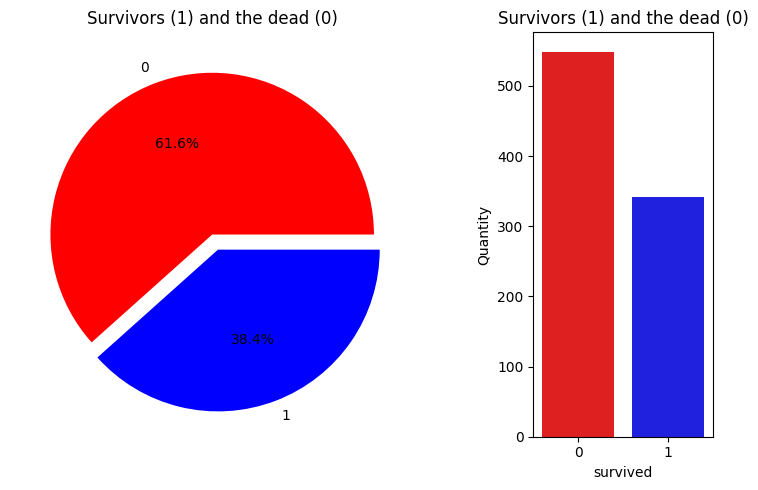

In [ ]:
# Make sure 'survived' is int (if it’s not already)
data['survived'] = data['survived'].astype(int)

# Define the color palette with integer keys
custom_palette = {0: 'red', 1: 'blue'}

# Create subplots
f, ax = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [3, 1]})

# Pie chart
data['survived'].value_counts().sort_index().plot.pie(
    explode=[0, 0.1],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=False,
    colors=[custom_palette[0], custom_palette[1]]  # red for 0, blue for 1
)
ax[0].set_title('Survivors (1) and the dead (0)')
ax[0].set_ylabel('')

# Countplot with hue workaround
sns.countplot(
    data=data,
    x='survived',
    hue='survived',
    ax=ax[1],
    palette=custom_palette,
    legend=False  # avoid duplicated legends
)
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survivors (1) and the dead (0)')

plt.tight_layout()
plt.show()

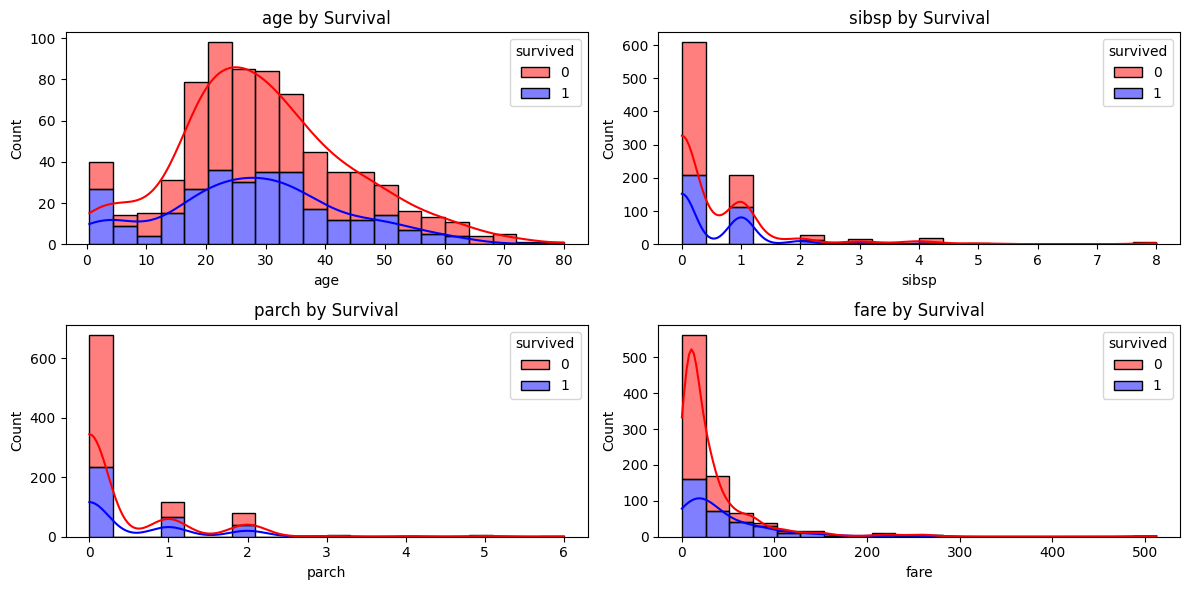

In [ ]:
# Distributions for all numeric variables

df_num = data[['age', 'sibsp', 'parch', 'fare', 'survived']]

cols = 2
rows = (len(df_num.columns) - 1 + 1) // cols  # Exclude 'survived' from count

# Define color palette
custom_palette = {0: 'red', 1: 'blue'}

plt.figure(figsize=(12, 6))
for i, col in enumerate(df_num.drop(columns='survived').columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(
        data=df_num,
        x=col,
        hue='survived',
        bins=20,
        kde=True,
        palette=custom_palette,  # Change to your preferred palette
        multiple='stack'  # Options: 'layer', 'dodge', 'stack', 'fill'
    )
    plt.title(f'{col} by Survival')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

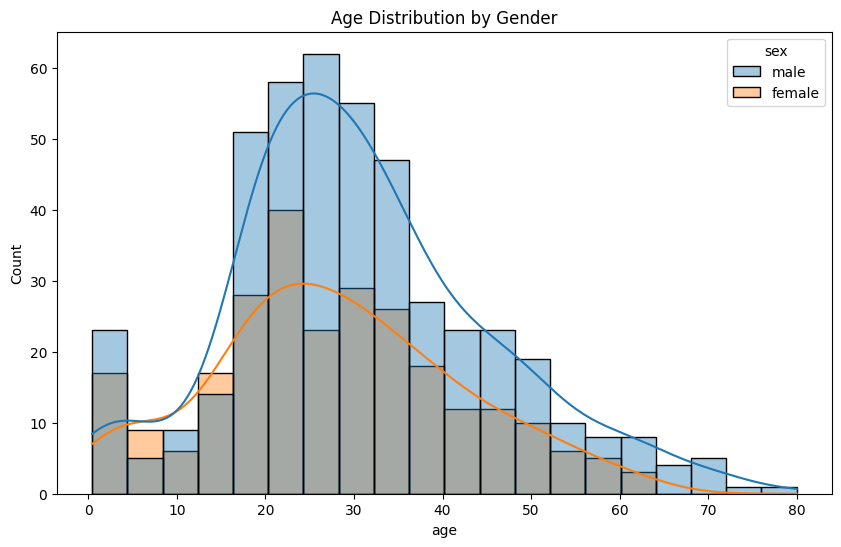

In [ ]:
# Distribution of ages of the passengers

plt.figure(figsize=(10, 6))
sns.histplot(
    data=data,
    x='age',
    kde=True,
    hue='sex',
    hue_order=['male', 'female'],
    alpha=0.4
)
plt.title('Age Distribution by Gender')
plt.show()

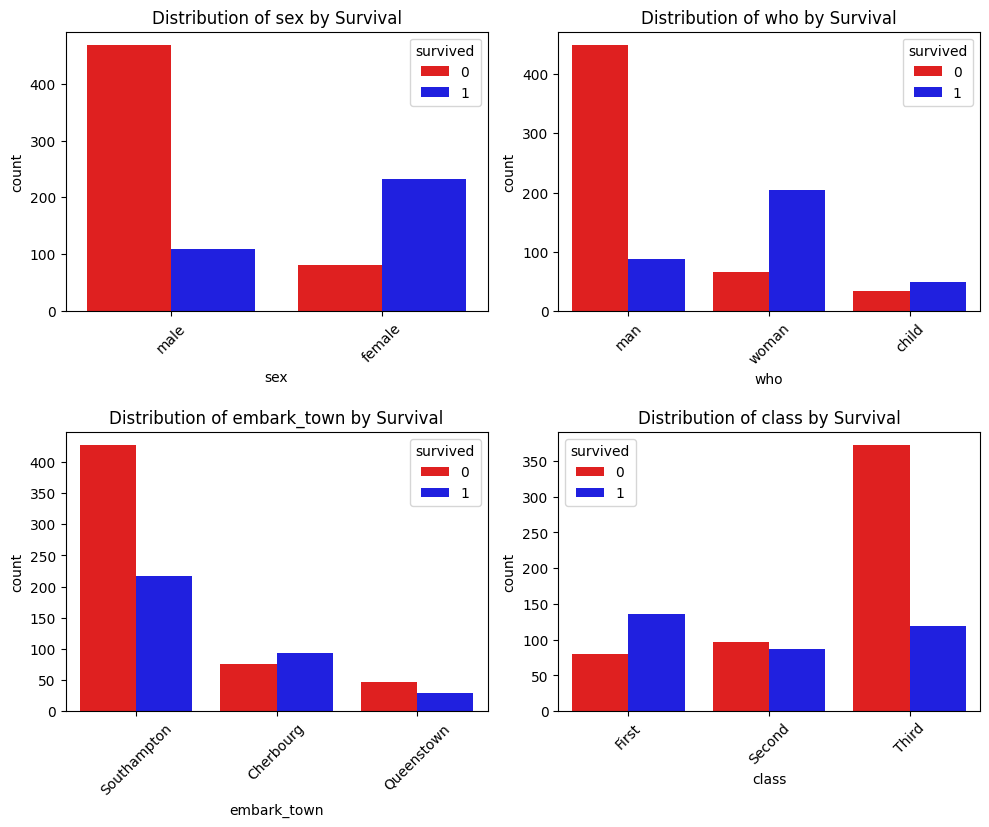

In [ ]:
# Select only categorical variables
cat_cols = data[['sex', 'who', 'embark_town', 'class']]

# Plot countplots for each categorical variable, faceted by 'survived'
n = len(cat_cols)
n_cols = 2  # 2 plots per row
n_rows = (n + 1) // n_cols

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data, x=col, hue='survived', palette=custom_palette)
    plt.title(f'Distribution of {col} by Survival')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

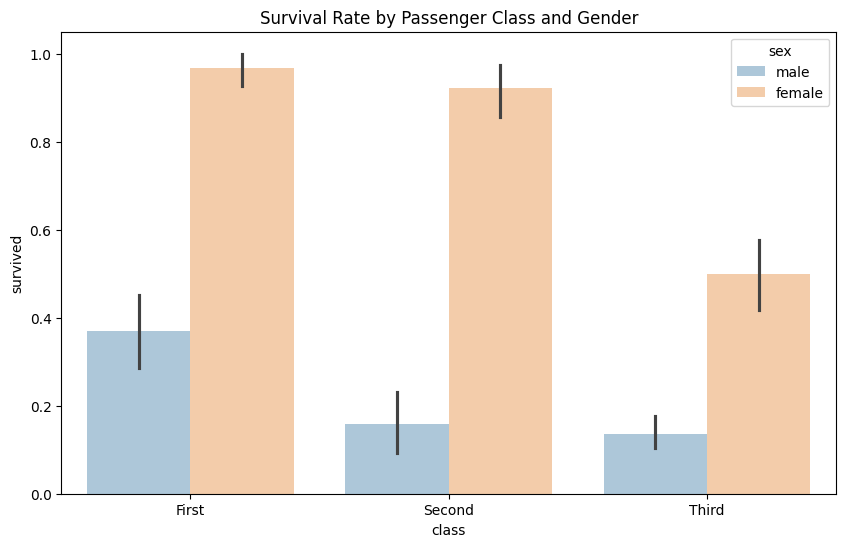

In [ ]:
# Survival Rate by Passenger Class and Gender

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='class', y='survived', hue='sex', alpha=0.4)
plt.title('Survival Rate by Passenger Class and Gender')
plt.show()

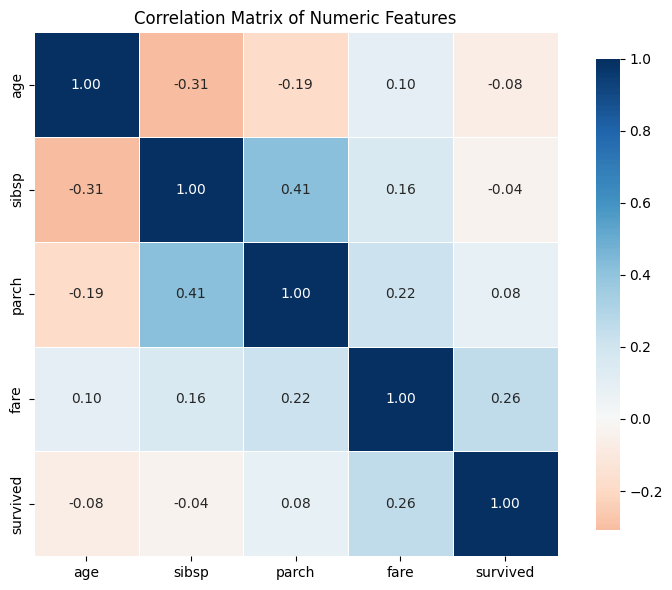

In [ ]:
# Calculate correlation matrix
corr_matrix = df_num.corr()

# Set up the plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,           # show correlation values in the cells
    fmt=".2f",            # format the numbers
    cmap= 'RdBu',         # color scheme
    center=0,             # center colormap at 0 for balance
    square=True,          # square cells
    linewidths=0.5,       # thin lines between squares
    cbar_kws={"shrink": .9}  # shrink colorbar
)

plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

## Feature Selection

In [8]:
# Feature Selection

features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = data[features]
y = data[target]

## Split the Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Model Pipeline

In [10]:
# Detect numerical and categorical columns and separate numeric and categorical
# features.

numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [12]:
# Define preprocessing transformers for both feature types

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
# Combine the transformers into a single column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [14]:
# Create a model pipeline

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [15]:
# Define a parameter grid for a cross validation search to optimize the model

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [16]:
# Perform grid search cross-validation and fit the best model

# Cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['pclass',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'class',
                                                                          'who'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [17]:
#  Print a classification report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



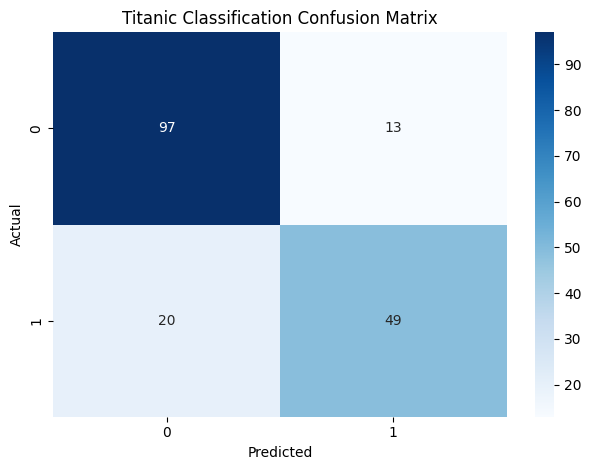

In [18]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
# Obtain the categorical feature importances

model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman'], dtype=object)

In [22]:
# Associate the feature importances with their one-hot encoded input features
# that were transformed from the original categorical features.
# And get all of the feature importances and associate them with their
# transformed feature names.

feature_importances = model.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(model.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

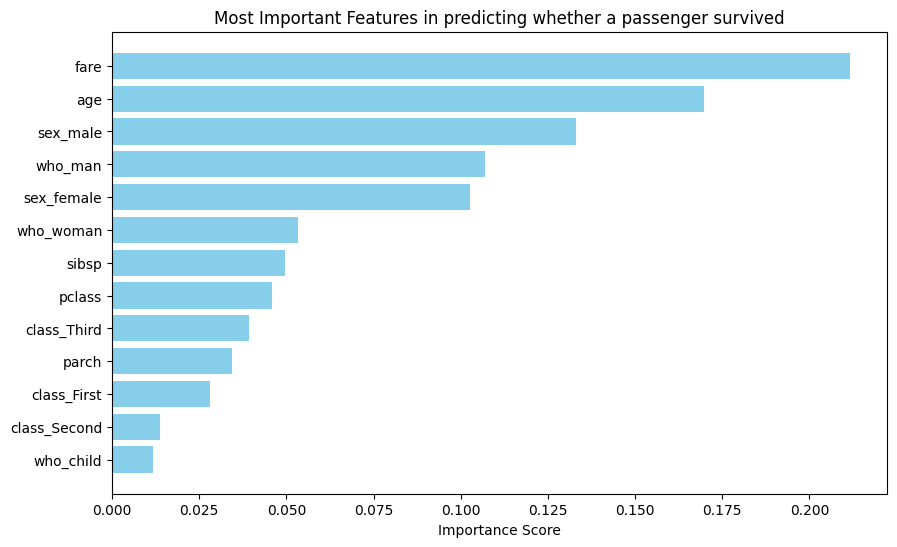


Test set accuracy: 81.56%


In [23]:
# Display the feature importances in a bar plot

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

## Another Model

In [24]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

model.param_grid = param_grid

# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



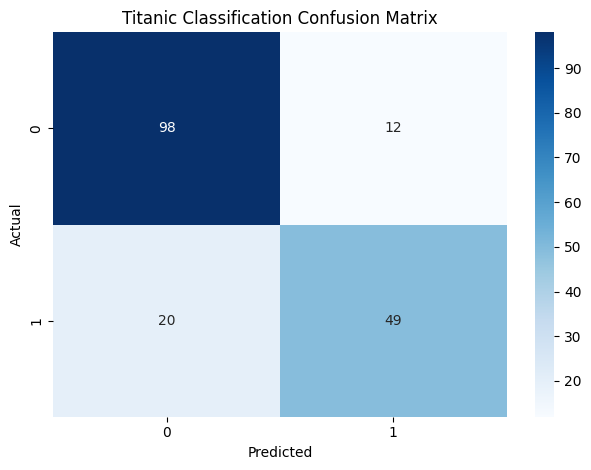

In [26]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

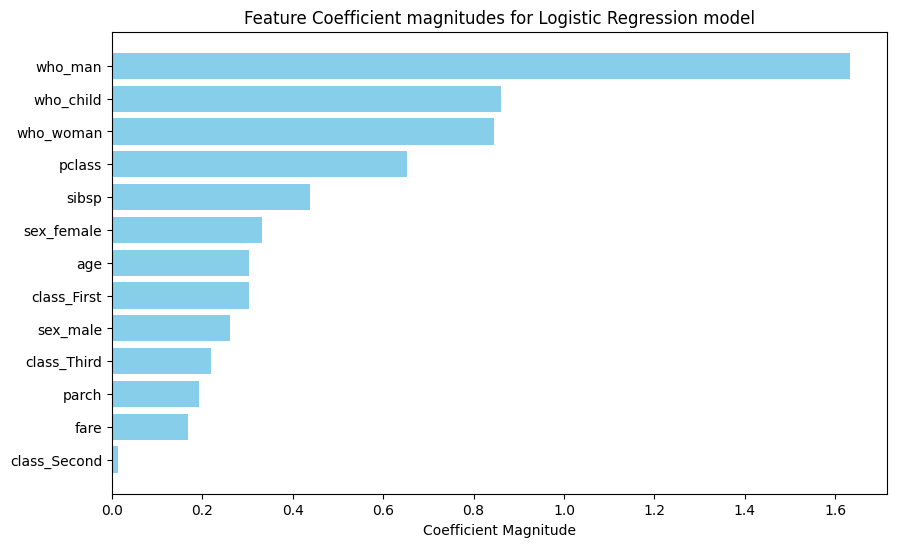


Test set accuracy: 82.12%


In [30]:
# Extract the logistic regression feature coefficients and plot a bar chart.

coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

# Combine numerical and categorical feature names
numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")